## [이미지 데이터 - 이진분류 모델]

-   데이터셋 : scikit-learn Fashion MNIST
-   데이터수 : 학습용 60000, 테스트용 10000
-   피쳐갯수 :
-   타겟갯수:


In [1]:
# 모듈 로딩
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

import torch
import torch.nn as nn  # LinearRegression기능의 클래스 Linear
import torch.nn.functional as F  # 손실함수
import torch.optim as optim  # 경사하강법 기반의 최적화 관련 모듈


In [2]:
### ===> 데이터 준비
fashion_db = "fashion-mnist"

fashion_data = fetch_openml(name=fashion_db, parser="auto")  # , as_frame=False)


In [3]:
### ===> 데이터 확인
feature = fashion_data.data
target = fashion_data.target


In [4]:
# 피쳐와 타겟 갯수 확인
print(f"FEATURE => {feature.shape}, {feature.ndim}D")
print(f"TARGET => {target.shape}, {target.ndim}D")


FEATURE => (70000, 784), 2D
TARGET => (70000,), 1D


In [5]:
# 분류 확인
print(f'FEATURE    => {fashion_data["feature_names"]}')
print(f'TARGET     => {fashion_data["target_names"]}')
print(f'CATEGORIES => {fashion_data["categories"]}')
print(f"CATEGORIES => {target.unique()}")


FEATURE    => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pix

[2] 데이터 가공 및 전처리 <hr>

-   결측치/중복/이상치 => 없음
-   다중분류 ==> 2진분류 변환 : target 변환
-   표준화 ==> 이미지 동일 크기 및 색상채널 : 동일 크기(28\*28)와 채널(흑백 1)
-   정규화 ==> 피쳐 정규화/타겟 정규화


In [6]:
### ===> [2-1] 다중분류 ==> 2진분류 변환 : target 변환
target = target == "0"
target.unique()


array([False,  True])

In [7]:
### ===> [2-2] 정규화 ==> 피쳐 : 784개 색상값 즉, 0 ~ 255 범위 값
norm_feature = feature / 255.0
norm_feature.head(2)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.0,0.0,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
### ===> [2-2] 정규화 ==> 타겟 : One-Hot 인코딩으로 변환
pd.get_dummies(target)


,False,True
0,True,False
1,False,True
2,False,True
3,True,False
4,False,True
...,...,...
69995,True,False
69996,True,False
69997,True,False
69998,True,False


In [9]:
from sklearn.preprocessing import OneHotEncoder

targetDF = target.to_frame()
print(targetDF.shape)


(70000, 1)


In [10]:
# sparse_out=False : ndarray 타입으로 반환
ohEncoder = OneHotEncoder(sparse_output=False)
ohEncoder.fit(targetDF)
ohEncoder.categories_


[array([False,  True])]

In [11]:
norm_target = ohEncoder.transform(targetDF)
norm_target.shape, norm_target.ndim


((70000, 2), 2)

[3] 학습 준비 <hr>

-   텐서화
-   데이터셋 준비 : 훈련용, 테스트용
-   학습 방법 : 지도학습 - 이진분류 => Linear 클래스 + sigmoid 함수
-   최적화방법 : 경사하강법 기반의 방법 => Adam, SGD, ...
-   손실함수 : 이진분류 손실 계산 함수 => binary_cross_entropy


In [12]:
### ===> 데이터셋 준비 : 60000개 훈련, 10000개 테스트
limit = 60000

train = norm_feature.iloc[:limit]
test = norm_feature.iloc[limit:]

train_y = norm_target[:limit]
test_y = norm_target[limit:]


In [13]:
print(f"train {train.shape}, {train.ndim}D, {train_y.shape}, {train_y.ndim}D")
print(f"test {test.shape}, {test.ndim}D, {test_y.shape}, {test_y.ndim}D")


train (60000, 784), 2D, (60000, 2), 2D
test (10000, 784), 2D, (10000, 2), 2D


In [14]:
### ===> 텐서로 변환
X_train = torch.FloatTensor(train.values)
X_test = torch.FloatTensor(test.values)

y_train = torch.FloatTensor(train_y)
y_test = torch.FloatTensor(test_y)


In [15]:
print(f"X_train {X_train.shape}, {X_train.ndim}D, {y_train.shape}, {y_train.ndim}D")
print(f"X_test {X_test.shape}, {X_test.ndim}D, {y_test.shape}, {y_test.ndim}D")


X_train torch.Size([60000, 784]), 2D, torch.Size([60000, 2]), 2D
X_test torch.Size([10000, 784]), 2D, torch.Size([10000, 2]), 2D


In [16]:
### 학습 인스턴스 생성
in_, out_ = X_train.shape[1], y_train.shape[1]
model = nn.Linear(in_, out_)
model


Linear(in_features=784, out_features=2, bias=True)

In [17]:
### 최적화 인스턴스 생성 => 모델에서 사용하는 W, b 변수들 전달
optimizer = optim.Adam(model.parameters())


In [18]:
### 학습 횟수 => 샘플 처음부터 끝까지 읽는 것 기준으로 횟수 지정
EPOCHS = 150


[4] 학습 <hr>

-   반복횟수만큼 학습 진행


In [20]:
loss_accuracy = [[], []]

for ep in range(EPOCHS + 1):
    # 학습
    pre_y = model(X_train)

    # 분류값 변환
    pre_y2 = F.sigmoid(pre_y)

    # 오차 즉 손실 계산
    loss = F.binary_cross_entropy(pre_y2, y_train)
    loss_accuracy[0].append(loss.item())
    print(f"[{ep}] Loss => {loss}")

    # W, b 업데이트
    optimizer.zero_grad()
    loss.backward()  # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
    optimizer.step()

    # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
    train_accuracy = (
        (y_train.argmax(dim=1) == pre_y2.argmax(dim=1)).sum()
    ) / y_train.shape[0]
    loss_accuracy[1].append(train_accuracy.item())


[0] Loss => 0.6307604312896729
[1] Loss => 0.562859833240509
[2] Loss => 0.5092499852180481
[3] Loss => 0.46835756301879883
[4] Loss => 0.43809589743614197
[5] Loss => 0.41625073552131653
[6] Loss => 0.40075692534446716
[7] Loss => 0.38984888792037964
[8] Loss => 0.3821081817150116
[9] Loss => 0.37644559144973755
[10] Loss => 0.37205344438552856
[11] Loss => 0.36834943294525146
[12] Loss => 0.36492568254470825
[13] Loss => 0.3615056276321411
[14] Loss => 0.35791075229644775
[15] Loss => 0.3540349304676056
[16] Loss => 0.34982532262802124
[17] Loss => 0.3452683091163635
[18] Loss => 0.34037908911705017
[19] Loss => 0.3351939916610718
[20] Loss => 0.32976454496383667
[21] Loss => 0.32415318489074707
[22] Loss => 0.3184293508529663
[23] Loss => 0.31266677379608154
[24] Loss => 0.3069399297237396
[25] Loss => 0.3013218939304352
[26] Loss => 0.2958810031414032
[27] Loss => 0.29067787528038025
[28] Loss => 0.28576263785362244
[29] Loss => 0.2811717689037323
[30] Loss => 0.2769259810447693
[3

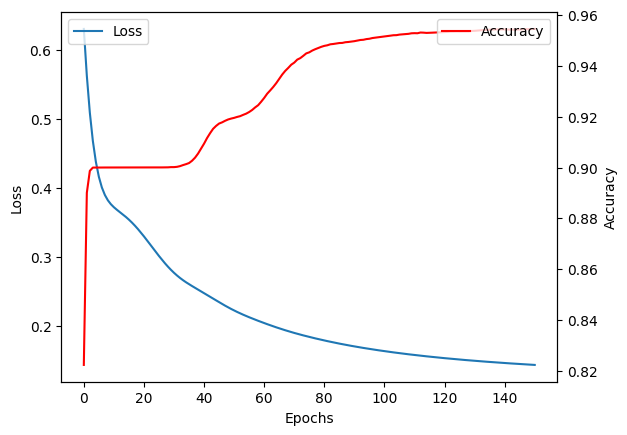

In [21]:
## 손실과 정확도 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(loss_accuracy[0], label="Loss")
ax1.legend(loc="upper left")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2 = ax1.twinx()
ax2.plot(loss_accuracy[1], label="Accuracy", color="red")
ax2.legend(loc="upper right")
ax2.set_ylabel("Accuracy")
plt.show()
